In [2]:
# Import packages define parameters for video
import base64
import cv2
from IPython.display import clear_output, display, HTML
import time
import sys
import numpy as np

videoSource_1 = "demo-1.mp4"
videoSource_2 = "demo-2.mp4"
videoSource_3 = "demo-3.mp4"

video = cv2.VideoCapture(videoSource)
ok, frame = video.read()

# Global Variables:
threshold = 15               # [10, 25] was the range in the paper
B = 9                        # Inverse learning rate = 2^B; B LSBs in centroids are for error term
div = 2**B                   # Divide by this to get the actual centroid value
P0 = 0.1                     # Probability threshold
K = 5                        # Number of centroids per cluster
DS = 5                       # Downscaling factor for faster processing 
# N x N x K  Array for Weights
weights = np.zeros((frame.shape[0]//DS, frame.shape[1]//DS, K)) 
# N x N x K x 3 Array for Centroids + Errors
centroid_and_errors = np.zeros((frame.shape[0]//DS, frame.shape[1]//DS, K, 3), dtype=int)

#***BOTH WEIGHTS AND CENTROIDS ARE SORTED FROM GREATEST TO LEAST WEIGHT***

In [3]:
# Match the pixel with the highest-weighted cluster centroid within T Manhattan distance of the pixel color
# Perform error adjustment like in Algorithm 2 in the paper
# Perform cluster replacement in this function if no matching cluster is found
def match_pixel(rgb_pixel, i, j):
    global centroid_and_errors
    global weights
    global div
    global threshold
    global K
    
    # param: (3, 256) pixel for each channel
    # return highest-weighted cluster that matches, -1 if no match
    # Must be sorted from greatest to least
    for cluster_idx in range(K):
        cluster = centroid_and_errors[i, j, cluster_idx] >> B # Integer division to remove error term
        
        # Calculate the Manhattan Distance
        distance = abs(cluster[0] - rgb_pixel[0]) + abs(cluster[1] - rgb_pixel[1]) + abs(cluster[2] - rgb_pixel[2]) # np.sum(np.abs(cluster - rgb_pixel))
        
        if distance < threshold:
            centroid_and_errors[i, j, cluster_idx] += rgb_pixel - cluster # Adjust error terms
            
            # Sort clusters
            arrinds = weights[i, j].argsort()
            weights[i, j] = weights[i, j, arrinds[::-1]]
            centroid_and_errors[i, j] = centroid_and_errors[i, j, arrinds[::-1]]
            for k in range(K):
                if k == cluster_idx:
                    weights[i, j, k] += (1-weights[i, j, k])//div
                else:
                    weights[i, j, k] += -weights[i, j, k]//div
            return cluster_idx
    
    # If a matching cluster was not found...
    # Replace lowest-weighted cluster with new cluster with centroid=pixel value and weight=0.01
    # Normalize cluster weights (this is the only time it needs to happen)
    centroid_and_errors[i, j, K-1] = rgb_pixel.astype(int)*div
    weights[i, j, K-1] = 0.01
    weightSum = 0
    for idx in range(K):
        weightSum += weights[i, j, idx]
    for idx in range(K):
        weights[i, j, idx] /= weightSum
    return -1 

def sort_clusters():
    global centroid_and_errors
    global weights
    # Sort cluster weights and centroids based on weight values, in descending order
    for i in range(len(weights)):
        for j in range(len(weights[i])):
            arrinds = weights[i, j].argsort()
            weights[i, j] = weights[i, j, arrinds[::-1]]
            centroid_and_errors[i, j] = centroid_and_errors[i, j, arrinds[::-1]]



def process_frame(frame):
    """
    (1) If no matching cluster is found, the lowest-weighted cluster is replaced with a new 
        cluster of low weight (0.01 in the paper)
    (2) Update all the weights according to equation 1 and add to the accumulated matching 
        error for the matched centroid, if new cluster was not made
    (3) Normalize Weights
    (4) Calculate P then classify
    Return new frame with segmentation
    """
    
    global weights
    global P0
    
    # Find P for each pixel and threshold it
    output = np.zeros((frame.shape[0], frame.shape[1]))
    
    for i in range(len(frame)):
        for j in range(len(frame[i])):
            pixel = frame[i, j]
            Mk = match_pixel(pixel, i, j)
            if Mk == -1:
                continue # Assume pixel is part of foreground if new centroid was created (is this a good idea?)
            elif Mk == 0:
                output[i, j] = 1
                continue # P = 0 if the centroid of greatest weight was selected (definitely background pixel)
            else:
                P = np.sum(weights[i, j, 0:Mk-1])
                if(P < P0): # Background pixel found
                    output[i, j] = 1
    return output



In [4]:
# Process video and play side-by-side with segmented output

def main_loop(videoSource):
    video = cv2.VideoCapture(videoSource)

    if not video.isOpened():
        print('Could not open video!')
    else:
        frameNum = 0
        t = time.time()
        fps = 0
        while True:
            # print("Frame:", frameNum)
            # print("FPS:", np.round(fps, 2))
            ret, frame = video.read()
            if not ret:
                break
            else:
                small_frame = cv2.resize(frame, (frame.shape[1]//DS, frame.shape[0]//DS))
                segmented_frame = (1-process_frame(small_frame))*255 # Invert segmented_frame to match paper

                # Processing segmentation as mentioned in the paper
                kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2))
                segmented_frame = cv2.morphologyEx(segmented_frame, cv2.MORPH_OPEN, kernel)
                kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
                segmented_frame = cv2.morphologyEx(segmented_frame, cv2.MORPH_CLOSE, kernel)

                # Scale segmented_frame up to size of frame
                segmented_frame = cv2.resize(segmented_frame, (frame.shape[1], frame.shape[0]))

                # Smooth and further process segmented_frame
    #             kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    #             segmented_frame = cv2.morphologyEx(segmented_frame, cv2.MORPH_OPEN, kernel)
    #             kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    #             segmented_frame = cv2.morphologyEx(segmented_frame, cv2.MORPH_ERODE, kernel)

                # Threshold segmented_frame
                ret, segmented_frame = cv2.threshold(segmented_frame, 100, 255, cv2.THRESH_BINARY)

                # sort_clusters()

                drawn_frame = np.zeros_like(frame)
                drawn_frame[:,:,0] = segmented_frame.astype(frame.dtype)
                drawn_frame[:,:,1] = segmented_frame.astype(frame.dtype)
                drawn_frame[:,:,2] = segmented_frame.astype(frame.dtype)

                frame_fg = frame*(drawn_frame//255)
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(10,10))/100
                frame_blurred = cv2.filter2D(frame,-1,kernel)

                frame = frame_fg + frame_blurred*((255*np.ones_like(drawn_frame)-drawn_frame)//255)

                combined_frame = cv2.hconcat([frame, drawn_frame])

                clear_output(wait=True)  # Clear the previous frame
                display(HTML("<img src='data:image/jpeg;base64," + base64.b64encode(cv2.imencode('.jpg', combined_frame)[1]).decode() + "'>"))
            frameNum += 1
            fps = 1/(time.time()-t)
            t = time.time()

# Test 1: Indoor with Lights on


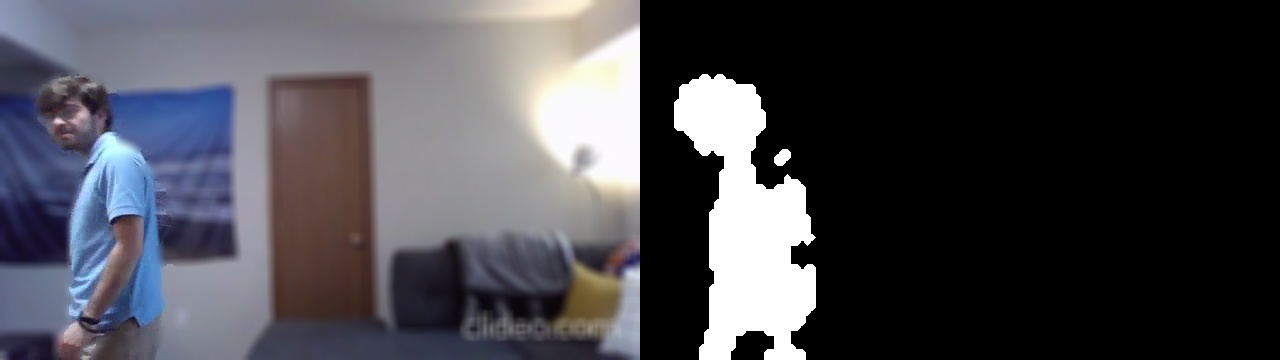

In [9]:
main_loop(videoSource_1)

# Test 2: Indoor with Lights off


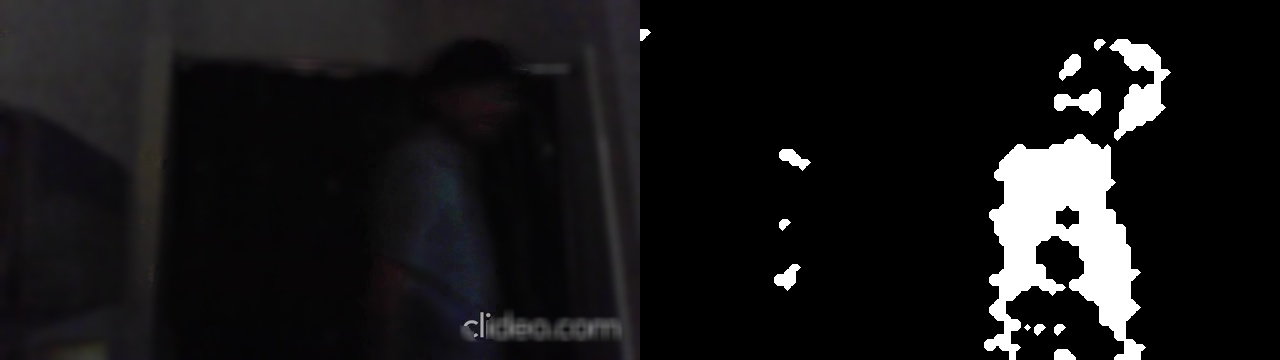

In [8]:
main_loop(videoSource_2)

# Test 3: Outside Light


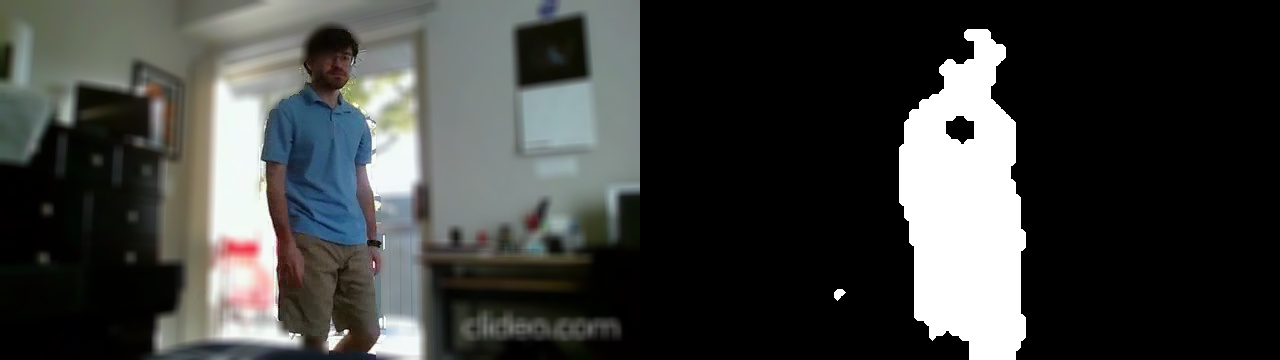

In [7]:
main_loop(videoSource_3)